# Homework 1 - Visualization
###  Name: Ty Nguyen
###  Student ID:   tynguyen

In this homework, I use Tensorflow framework

# 1. Plot Loss and Gradient (20%)
In this part, you will write code to plot the output and gradient for a single neuron with Sigmoid activation and two different loss functions. As shown in Figure 1, You should
implement a single neuron with input 1, and calculate different losses and corresponding
error.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import time, os
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline  

In [2]:
class SIGMOID():
    def set_weights(self,w):
        self.w = w 
    def set_biases(self,b):
        self.b = b 
    def sigmoid(self,x):
        return 1./(1 + np.exp(-(self.w*x + self.b)))
    
def _L2_loss(y, y_predict):
	return (y - y_predict)**2 

def _grad_L2(y, y_pred, x):
    return 2*(y_pred - y)*y_pred *(1-y_pred)*x

def _cross_entropy_loss(y, y_predict):
    if isinstance(y_predict, np.ndarray):
        y_predict = y_predict + 1e-8*(y_predict==0) - 1e-8*(y_predict==1)
	return -(y*np.log2(y_predict) + (1-y)*np.log2(1-y_predict))

def _grad_cross_entropy(y, y_pred, x):
    return - (y/(y_pred *np.log(2))- (1-y)/( (1-y_pred)*np.log(2))) * y_pred*(1-y_pred)*x

In [141]:
import tensorflow as tf
import numpy as np
import math 
def draw_accu_loss(accuracy_set, loss_set):
    plt.figure(figsize=(12, 5))
    fig = plt.subplot(121)
    plt.plot(range(len(accuracy_set)), accuracy_set)
    fig.set_title('Accuracy')
    fig.set_xlabel('Iterations')
    fig.set_ylabel('Accuracy (%)')

    fig = plt.subplot(122)
    plt.plot(range(len(loss_set)), loss_set)
    fig.set_title('Loss')
    fig.set_xlabel('Iterations')
    fig.set_ylabel('Loss')

learning_rate = 0.1
batch_size = 64
num_epoches = 2000
num_iters_per_epoch =  5

# 3. Experiment with Convolutional Network (30%)
In this part, you will explore the convolutional networks. By doing experiments, you will
experience how convolutional networks learn to interpret images and capture meaningful
structure. Construct a convolutional network as shown in Figure 4.

In [155]:
class CNN(object):
    @classmethod
    def init_weights(clc, shape, name):
        """ Weight initialization """
        weights = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(weights, name=name)
    @classmethod 
    def init_biases(clc, shape,  name):
        """ Bias initialization """
        biases = 0.1*tf.ones(shape, dtype=tf.float32)
        return tf.Variable(biases, name=name)
    @classmethod 
    def sigmoid_cross_entropy(clc, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits, name='cross_entropy_loss')
        return tf.reduce_mean(loss)
    @classmethod 
    def sigmoid_activation(clc, x):
        return tf.nn.sigmoid(x) 
    @classmethod
    def relu_activation(clc, x):
        return tf.nn.relu(x)
    @classmethod 
    def sigmoid_L2(clc, labels, logits): 
        out_fc2 = tf.nn.sigmoid(logits) 
        loss = tf.square(out_fc2 - labels) 
        loss = tf.reduce_mean(loss) 
        return loss      
    @classmethod
    def plrelu_activation(clc, x):
        output = tf.maximum(x, 0) - 0.01*tf.maximum(-x, 0) - 0.85*tf.maximum(x-10, 0)
 
        return output 

    @classmethod 
    def plotNNFilter(clc,units):
        print 'units shape:', units.shape
        filters = units.shape[3]
        plt.figure(1, figsize=(20,20))
        n_columns = 6
        n_rows = math.ceil(filters / n_columns) + 1
        for i in range(filters):
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('Filter ' + str(i))
            plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

    def __init__(self, activation_fnc, loss_fnc):
        activation_function_list=  {'sigmoid_activation':self.sigmoid_activation, \
                                    'relu_activation':self.relu_activation, 'plrelu_activation':self.plrelu_activation}
        loss_function_list = {'sigmoid_cross_entropy':self.sigmoid_cross_entropy, 'sigmoid_L2':self.sigmoid_L2}
        self.activation = activation_function_list[activation_fnc] if activation_fnc else self.sigmoid_activation 
        self.loss = loss_function_list[loss_fnc] if loss_fnc else self.sigmoid_cross_entropy
        
            
    def train(self, images_expanded, labels, layer=None): 
        # Initialize a network 
        with tf.device('/cpu:0'):
            with tf.name_scope('input'):
                x = tf.placeholder(tf.float32, [None,16,16,1], name='x-input')
                y = tf.placeholder(tf.float32, [None,2], name='labels')

        with tf.name_scope('conv1'):
            f1_size = 7 
            f1_depth = 16 
          
            w1 = self.init_weights([f1_size, f1_size, 1, f1_depth], 'w_conv1')
            b1 = self.init_biases((f1_depth), 'b_conv1')
            
            conv1 = tf.nn.conv2d(input=x, filter=w1,
                                        strides=[1, 1, 1, 1],
                                        padding='SAME')  
            
            with tf.name_scope('activation'):
                out_conv1 = self.activation(conv1 + b1)

        with tf.name_scope('conv2'):
            f2_size = 7 
            f2_depth = 8 
            w2 = self.init_weights([f2_size, f2_size, f1_depth, f2_depth], 'w_conv2')
            b2 = self.init_biases((f2_depth), 'b_conv2')
            
            conv2 = tf.nn.conv2d(input=out_conv1, filter=w2,
                                        strides=[1, 1, 1, 1],
                                        padding='SAME')  
            
            with tf.name_scope('activation'):
                out_conv2 = self.activation(conv2 + b2)  
        
        # Reshape out_conv2 
        out_conv2_shape = out_conv2.get_shape().as_list()
        out_conv2_dim = out_conv2_shape[1]
        out_conv2_flat = tf.reshape(out_conv2, [-1, out_conv2_dim*out_conv2_dim*f2_depth])
        with tf.name_scope('fc3'):
            w3 = self.init_weights((out_conv2_dim*out_conv2_dim*f2_depth, 2), 'w_fc3')
            b3 = self.init_biases((2), 'b_fc3')
            with tf.name_scope('activation'):
                out_fc3 = self.activation(tf.matmul(out_conv2_flat , w3) + b3)
                
            logits = tf.matmul(out_conv2_flat , w3) + b3
            predict = tf.argmax(logits, axis=1)
            correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))

            loss = self.loss(labels=y, logits=logits) 

        # Gradient descent 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        global_step = tf.contrib.framework.get_or_create_global_step()
#         global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step=global_step)
        
        saver = tf.train.Saver(max_to_keep=2)
        # Run  
        sess = tf.Session()     
       
        print'\n**************Reinitialize hyperparamters!!!**************'
        sess.run(tf.global_variables_initializer())
       
        # Using mini-batch training 
        def _feed_dict(batch_size):
            indices = np.random.choice(64, batch_size)
            sample_images = images_expanded[indices,...]
            sample_labels = labels[indices, ...]
            return {x: sample_images, y: sample_labels} #, batch_size_holder:batch_size}
        accuracy_set = [] 
        loss_set = [] 
        train_flag = True
  
        for epoch in range(num_epoches):
            if train_flag == False:
                break 
            for iter in range(num_iters_per_epoch):
                # Train 
                _ = sess.run([train_op],feed_dict=_feed_dict(batch_size))

                # Test 
                y_pred, loss_val, gt, prop_pred, correct_set = sess.run([predict, loss, y, logits, correct_prediction],\
                                                                           feed_dict={x: images_expanded, y: labels})
                # Store results 
                train_accuracy = np.mean(correct_set)
                accuracy_set.append(train_accuracy*100)
                loss_set.append(loss_val)
                # Stop if accuracy is good 
                if train_accuracy == 1.0:
                    train_flag = False 
                    break 
#             print("Epoch = %d, loss = %.2f, train accuracy = %.2f%%") % (epoch + 1, loss_val, 100. * train_accuracy)

        saved = saver.save(sess, 'model.ckpt',global_step=epoch)
    
        # visualize 
        sample_image = np.expand_dims(images_expanded[0,...],0)
        sample_label= np.expand_dims(labels[0,...],0) 
        print sample_image.shape
        plt.figure()
        plt.imshow(images_expanded[0,...,0])
        plt.title('Sample Image')
        plt.show()
        
        layer_dict = {'conv1':conv1, 'conv2':conv2}
        print layer_dict[layer]
        units = sess.run(layer_dict[layer],feed_dict={x:sample_image,y:sample_label})
        self.plotNNFilter(units)
       
    
        sess.close()
        return accuracy_set, loss_set 
        



In [156]:
# Retrieve image data 
images = np.load('./data/line/line_imgs.npy')
labels = np.load('./data/line/line_labs.npy')
 
labels = np.expand_dims(labels,1)
labels = np.concatenate((labels, 1 - labels), axis=1).astype(np.float32)

### 1. (15%) Experiment with the line dataset (Figure 5). You will construct a network with two convolutional layers and one fully connected layer, concatenated with a  cross-entropy loss. (A standard classification network.) Use ReLU as the activation functions of convolutional layers. Plot two figures showing 1) loss vs training iterations, and 2) accuracy vs training iterations. Stop the training when accuracy reaches 100%. Compare the results with part 2.

(64, 16, 16, 1)

**************Reinitialize hyperparamters!!!**************
(1, 16, 16, 1)


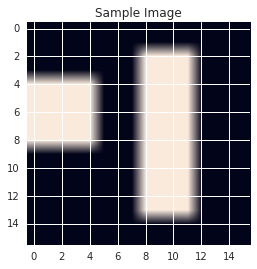

Tensor("conv2_50/Conv2D:0", shape=(?, 16, 16, 8), dtype=float32)
units shape: (1, 16, 16, 8)


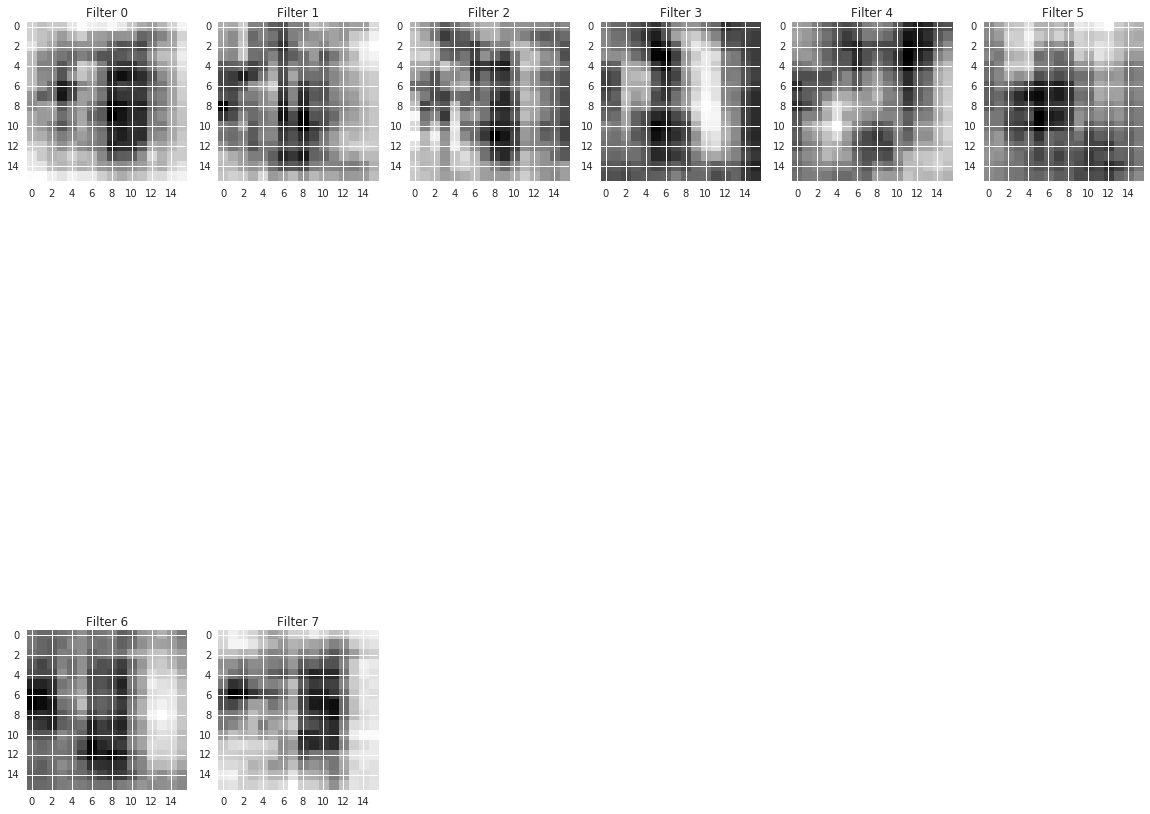

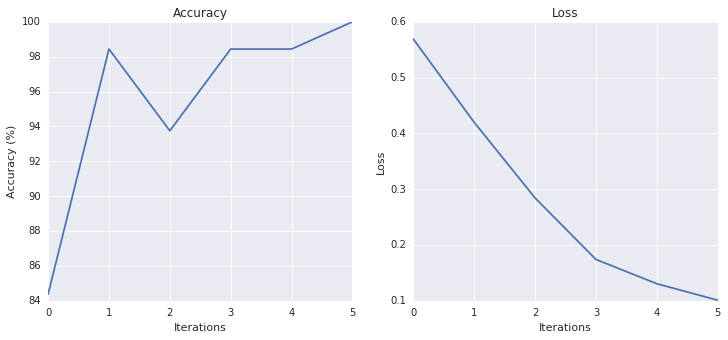

In [157]:
images_expanded = np.expand_dims(images, 3)
print images_expanded.shape
CNN_ins = CNN('relu_activation', 'sigmoid_cross_entropy')
accuracy_set, loss_set = CNN_ins.train(images_expanded, labels, 'conv2') 

draw_accu_loss(accuracy_set, loss_set)

In [ ]:
# Visualize the activations 
sample_label = labels[0,...]
sample_images = images_expanded[0,...]
plt.figure() 
plt.imshow(sample_images[...,0])
plt.title('Sample image')
CNN_ins = CNN('relu_activation', 'sigmoid_cross_entropy')
CNN_ins.train(images_expanded, labels, VISUALIZE=True, layer='conv1')




#### Comparing with part 2, we can see that the training is much faster as the accuracy can reach 100% after only a few iterations. 

### 2. (15%) Experiment with the detection dataset (Figure 5). Use the same network architecture from the previous questions. In addition, add one more fully connected  layer on top of the convolutional layer. This fully connected layer (with linear activation) acts as a regressor, followed by an L2 loss. It is used to predict the width of the object. The learning rate for L2 loss is set to 0.001. We define the regression prediction is correct if the predicted width is within 0.5 of the ground truth width.

In [117]:
# Retrieve image data 
images = np.load('./data/detection/detection_imgs.npy')
labels = np.load('./data/detection/detection_labs.npy')
widths = np.load('./data/detection/detection_width.npy')
 
labels = np.expand_dims(labels,1)
widths = np.expand_dims(widths,1).astype(np.float32)
labels = np.concatenate((labels, 1 - labels), axis=1).astype(np.float32)
images_expanded = np.expand_dims(images, 3)

print widths.shape
print images_expanded.shape
 

(64, 1)
(64, 16, 16, 1)


In [118]:
class CNN2(object):
    @classmethod
    def init_weights(clc, shape, name):
        """ Weight initialization """
        weights = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(weights, name=name)
    @classmethod 
    def init_biases(clc, shape,  name):
        """ Bias initialization """
        biases = 0.1*tf.ones(shape, dtype=tf.float32)
        return tf.Variable(biases, name=name)
    @classmethod 
    def sigmoid_cross_entropy(clc, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits, name='cross_entropy_loss')
        return tf.reduce_mean(loss)
    @classmethod 
    def sigmoid_activation(clc, x):
        return tf.nn.sigmoid(x) 
    @classmethod
    def relu_activation(clc, x):
        return tf.nn.relu(x)
    @classmethod 
    def sigmoid_L2(clc, labels, logits): 
        out_fc2 = tf.nn.sigmoid(logits) 
        loss = tf.square(out_fc2 - labels) 
        loss = tf.reduce_mean(loss) 
        return loss 
    @classmethod
    def plrelu_activation(clc, x):
        output = tf.maximum(x, 0) - 0.01*tf.maximum(-x, 0) - 0.85*tf.maximum(x-10, 0)
 
        return output 

        
    
    def __init__(self, activation_fnc, loss_fnc):
        activation_function_list=  {'sigmoid_activation':self.sigmoid_activation, \
                                    'relu_activation':self.relu_activation, 'plrelu_activation':self.plrelu_activation}
        loss_function_list = {'sigmoid_cross_entropy':self.sigmoid_cross_entropy, 'sigmoid_L2':self.sigmoid_L2}
        self.activation = activation_function_list[activation_fnc] if activation_fnc else self.sigmoid_activation 
        self.loss = loss_function_list[loss_fnc] if loss_fnc else self.sigmoid_cross_entropy
        
            
    def train(self, images, labels, widths): 
        # Initialize a network 
        with tf.device('/cpu:0'):
            with tf.name_scope('input'):
                x = tf.placeholder(tf.float32, [None,16,16,1], name='x-input')
                y = tf.placeholder(tf.float32, [None,2], name='labels')
                w_ts =  tf.placeholder(tf.float32, [None,1], name='labels')

        with tf.name_scope('conv1'):
            f1_size = 7 
            f1_depth = 16 
            w1 = self.init_weights([f1_size, f1_size, 1, f1_depth], 'w_conv1')
            b1 = self.init_biases((f1_depth), 'b_conv1')
            
            conv1 = tf.nn.conv2d(input=x, filter=w1,
                                        strides=[1, 1, 1, 1],
                                        padding='SAME')  
            
            with tf.name_scope('act_conv1'):
                out_conv1 = self.activation(conv1 + b1)

        with tf.name_scope('conv2'):
            f2_size = 7 
            f2_depth = 8 
            w2 = self.init_weights([f2_size, f2_size, f1_depth, f2_depth], 'w_conv2')
            b2 = self.init_biases((f2_depth), 'b_conv2')
            
            conv2 = tf.nn.conv2d(input=out_conv1, filter=w2,
                                        strides=[1, 1, 1, 1],
                                        padding='SAME')  
            
            with tf.name_scope('act_conv2'):
                out_conv2 = self.activation(conv2 + b2)  
        
        # Reshape out_conv2 
        out_conv2_shape = out_conv2.get_shape().as_list()
        out_conv2_dim = out_conv2_shape[1]
        out_conv2_flat = tf.reshape(out_conv2, [-1, out_conv2_dim*out_conv2_dim*f2_depth])
        # Classification 
        with tf.name_scope('fc3'):
            w3 = self.init_weights((out_conv2_dim*out_conv2_dim*f2_depth, 2), 'w_fc3')
            b3 = self.init_biases((2), 'b_fc3')
            with tf.name_scope('act_fc3'):
                out_fc3 = self.activation(tf.matmul(out_conv2_flat , w3) + b3)
                
            logits = tf.matmul(out_conv2_flat , w3) + b3
            predict = tf.argmax(logits, axis=1)
            correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))

            loss_classification = self.loss(labels=y, logits=logits) 
            
        # Regression 
        with tf.name_scope('fc4'):
            w4 = self.init_weights((out_conv2_dim*out_conv2_dim*f2_depth, 2), 'w_fc4')
            b4 = self.init_biases((2), 'b_fc4')
            with tf.name_scope('act_fc4'):
                w_pred = tf.matmul(out_conv2_flat , w4) + b4
            # L2 loss on dimension regression 
            loss_dimension = tf.square(w_pred - w_ts) 
            loss_dimension = tf.reduce_mean(loss_dimension) 
            # Regression accuracy 
            delta_width = tf.square(w_pred - w_ts)
            correct_regression = tf.cast(tf.less_equal(delta_width, 0.5*tf.square(w_ts)), tf.float32)
            accuracy_regression = tf.reduce_mean(correct_regression)
            

        # Gradient descent 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        loss = loss_classification + loss_factor*loss_dimension
        train_op = optimizer.minimize(loss, global_step=global_step)

        # Run  
        sess = tf.Session()
        init = tf.global_variables_initializer()
        sess.run(init)

        # Using mini-batch training 
        def _feed_dict(batch_size):
            indices = np.random.choice(64, batch_size)
            sample_images = images[indices,...]
            sample_labels = labels[indices, ...]
            sample_widths = widths[indices,...]
            return {x: sample_images, y: sample_labels, w_ts:sample_widths} #, batch_size_holder:batch_size}
        class_accuracy_set = [] 
        cross_entropy_loss_set = [] 
        total_loss_set = [] 
        L2_loss_set = [] 
        regression_accuracy_set = [] 
        train_flag = True

        for epoch in range(num_epoches):
            if train_flag == False:
                break 
            for iter in range(num_iters_per_epoch):
                # Train 
                _ = sess.run([train_op],feed_dict=_feed_dict(batch_size))

                # Test 
                total_loss, correct_set, cross_entropy_loss, L2_loss, regression_accuracy = sess.run(\
                                 [loss, correct_prediction, loss_classification, loss_dimension, accuracy_regression],\
                                  feed_dict={x: images_expanded, y: labels, w_ts: widths})
                # Store results 
                train_accuracy = np.mean(correct_set)
                class_accuracy_set.append(train_accuracy*100)
                total_loss_set.append(total_loss)
                regression_accuracy_set.append(regression_accuracy*100)
                L2_loss_set.append(L2_loss)
                cross_entropy_loss_set.append(cross_entropy_loss)
                # Stop if accuracy is good 
                if regression_accuracy == 1.0:
                    train_flag = False 
                    break 
#             print("Epoch = %d, loss = %.2f, class accuracy = %.2f%%, reg accuracy = %.2f%%") % (epoch + 1, total_loss, 100. * train_accuracy, 100.*regression_accuracy)
        sess.close()
        return class_accuracy_set, cross_entropy_loss_set, total_loss_set, L2_loss_set, regression_accuracy_set



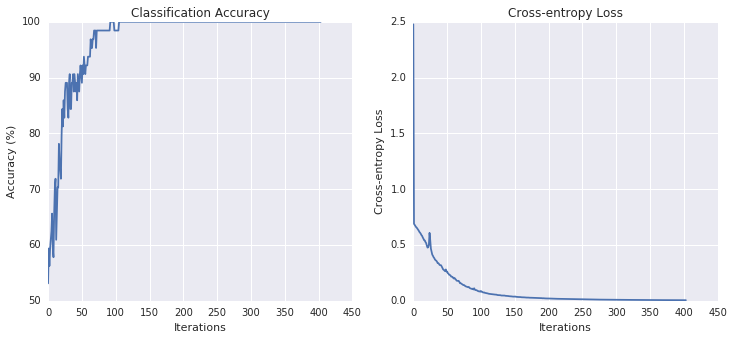

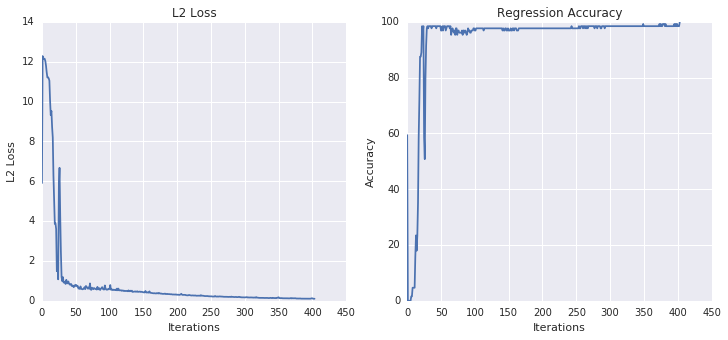

In [104]:
loss_factor = 0.01 
images_expanded = np.expand_dims(images, 3)
CNN_ins = CNN2('relu_activation', 'sigmoid_cross_entropy')
class_accuracy_set, cross_entropy_loss_set, total_loss_set, L2_loss_set, regression_accuracy_set = CNN_ins.train(images_expanded, labels, widths) 

 
plt.figure(figsize=(12, 5))
fig = plt.subplot(121)
plt.plot(range(len(class_accuracy_set)), class_accuracy_set)
fig.set_title('Classification Accuracy')
fig.set_xlabel('Iterations')
fig.set_ylabel('Accuracy (%)')

fig = plt.subplot(122)
plt.plot(range(len(cross_entropy_loss_set)), cross_entropy_loss_set)
fig.set_title('Cross-entropy Loss')
fig.set_xlabel('Iterations')
fig.set_ylabel('Cross-entropy Loss')

plt.figure(figsize=(12, 5))
fig = plt.subplot(121)
plt.plot(range(len(L2_loss_set)), L2_loss_set)
fig.set_title('L2 Loss')
fig.set_xlabel('Iterations')
fig.set_ylabel('L2 Loss')

fig = plt.subplot(122)
plt.plot(range(len(regression_accuracy_set)), regression_accuracy_set)
fig.set_title('Regression Accuracy')
fig.set_xlabel('Iterations')
fig.set_ylabel('Accuracy')


#### Comparing with the previous question, we can see that the training is slower as it takes more iterations to reach 100% accuracy in classification. This can be explained by the fact that the network has to do more work, not only to classify but also to regress the width of the object. 


# 4. Customize Activation Function (30%)
In this part, implement one customize activation function and re-do the experiments of
part 1 and part 3 using the exact same setting except activation functions.
You are welcome to invent a new activation function and test it out. Or you can implement
one novel activation function that is proposed in the literature. Some candidate activation
functions include variants of ReLU [4], e.g., leaky ReLU, parametric ReLU, randomized
6ReLU, or concatenated ReLU [3]. You are also welcome to investigate exponential linear
units (ELU) [1] or scaled exponential linear units (SELU) [2].


### 1. (10%) Implement one customized activation function and re-do the analysis of part 1. Plot three 3D figures showing 1) output, 2) loss, and 3) gradient versus weight/bias.

I define an activation function based on Leak ReLU (LRELU) function as follows
$$ f(x) = \max(0,x) - \alpha \max(0, -x) - \beta \max(0, x - \gamma)$$
where $\alpha, \beta, \gamma > 0$ are predefined parameters. 
This function, can be called as Piece-wise Linear ReLU (PLRELU), has all properties of LRELU while is less likely to blow up when $x$ becomes large. 

In [119]:
class PLRELU():
    def __init__(self, alpha=0.01, beta=0.88, gamma=5):
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma 
    def set_weights(self,w):
        self.w = w 
    def set_biases(self,b):
        self.b = b 
    def relu(self,x):
        x = self.w*x + self.b 
        if isinstance(x, np.ndarray):
            zeros = np.zeros_like(x)
            twos = 2 + np.zeros_like(x)
            output = np.maximum.reduce([x, zeros]) + self.alpha*np.maximum.reduce([-x, zeros])\
                             - self.beta*np.maximum.reduce([x-2, zeros])
        else:
            output = np.max([0, x]) + self.alpha*np.max([0, -x]) - self.beta*np.max([0, x-self.gamma])
            print output
        return output 

def subplot_3d(fig, w_set, b_set, output_set, title='Sigmoid Output', xlabel='Weights', ylabel='Biases'):
    ax = fig.gca(projection='3d')
    # Plot the surface.
    surf = ax.plot_surface(w_set, b_set, output_set, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # ax.set_zlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.show() 
    

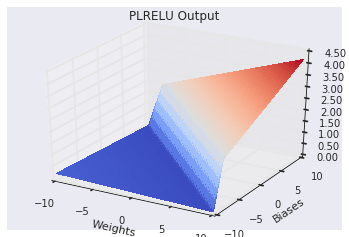

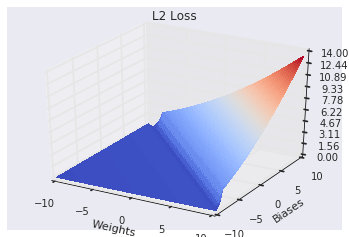

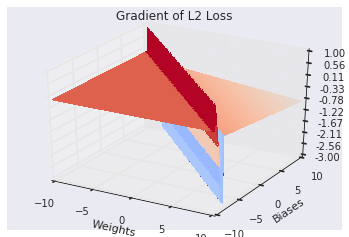

In [120]:
x = 1
w_set = np.linspace(-10, 10, 500)
b_set = np.linspace(-10, 10, 500)

w_set, b_set = np.meshgrid(w_set, b_set)
 
plrelu_ins = PLRELU()
plrelu_ins.set_weights(w_set)
plrelu_ins.set_biases(b_set)
output_set = plrelu_ins.relu(x)

fig = plt.figure()
subplot_3d(fig, w_set, b_set, output_set, title='PLRELU Output', xlabel='Weights', ylabel='Biases')


######################################
# L2 Loss 
y = 0.5 
L2_loss_set = _L2_loss(y, output_set)
fig = plt.figure()
# Plot the surface.
subplot_3d(fig, w_set, b_set, L2_loss_set, title='L2 Loss', xlabel='Weights', ylabel='Biases')


######################################
# Numerical gradient of L2 Loss 
delta_w = 0.0001
w_set = np.linspace(-10, 10, 500)
b_set = np.linspace(-10, 10, 500)
w_set_left = w_set - delta_w 
w_set_right = w_set + delta_w 
 
w_set_left, _ = np.meshgrid(w_set_left, b_set)
w_set_right, _ = np.meshgrid(w_set_right, b_set)
w_set, b_set = np.meshgrid(w_set, b_set)

p2lrelu_ins = PLRELU()
p2lrelu_ins.set_weights(w_set_left)
p2lrelu_ins.set_biases(b_set)
output_set_left = p2lrelu_ins.relu(x)
L2_loss_left = _L2_loss(y, output_set_left)

p2lrelu_ins.set_weights(w_set_right)
p2lrelu_ins.set_biases(b_set)
output_set_right = p2lrelu_ins.relu(x)
L2_loss_right = _L2_loss(y, output_set_right)

num_grad_L2_loss_set = (L2_loss_left -L2_loss_right)/(2.0*delta_w)

fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
subplot_3d(fig, w_set, b_set, num_grad_L2_loss_set, title='Gradient of L2 Loss', xlabel='Weights', ylabel='Biases')


#### Since this loss function has no bound, cross-entropy is undefined under this loss. Thus, I ignore analyzing the cross-entropy loss and its gradient.

### 2. (10%) Re-do the experiment in part 3. Plot all relevant figures (6 in total).

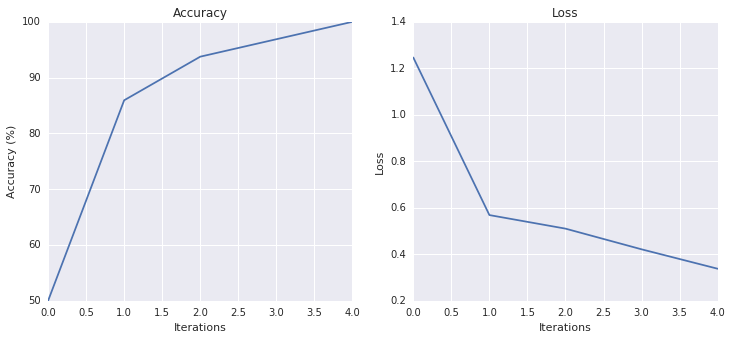

In [121]:
# Retrieve image data 
images = np.load('./data/line/line_imgs.npy')
labels = np.load('./data/line/line_labs.npy')
 
labels = np.expand_dims(labels,1)
labels = np.concatenate((labels, 1 - labels), axis=1).astype(np.float32)
images_expanded = np.expand_dims(images, 3)
CNN_ins = CNN('plrelu_activation', 'sigmoid_cross_entropy')
accuracy_set, loss_set = CNN_ins.train(images_expanded, labels) 

draw_accu_loss(accuracy_set, loss_set)

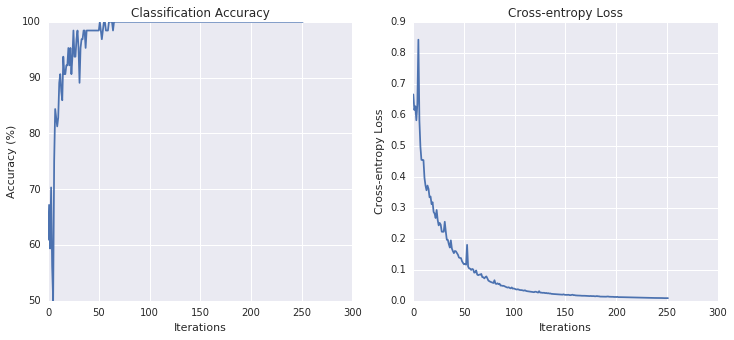

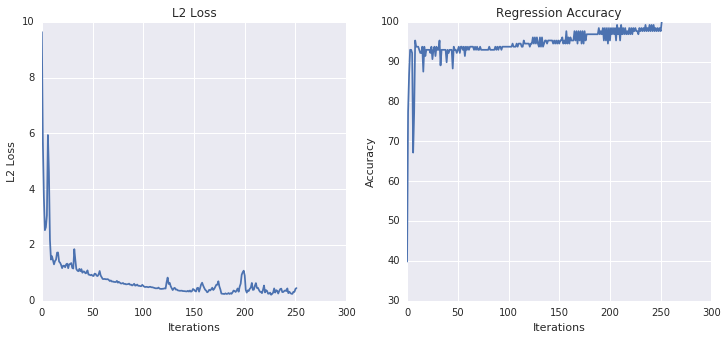

In [124]:
loss_factor = 0.01
# Retrieve image data 
images = np.load('./data/detection/detection_imgs.npy')
labels = np.load('./data/detection/detection_labs.npy')
widths = np.load('./data/detection/detection_width.npy')
 
labels = np.expand_dims(labels,1)
widths = np.expand_dims(widths,1).astype(np.float32)
labels = np.concatenate((labels, 1 - labels), axis=1).astype(np.float32)
images_expanded = np.expand_dims(images, 3)

CNN_ins = CNN2('plrelu_activation', 'sigmoid_cross_entropy')
class_accuracy_set, cross_entropy_loss_set, total_loss_set, L2_loss_set, regression_accuracy_set = CNN_ins.train(images_expanded, labels, widths) 

 
plt.figure(figsize=(12, 5))
fig = plt.subplot(121)
plt.plot(range(len(class_accuracy_set)), class_accuracy_set)
fig.set_title('Classification Accuracy')
fig.set_xlabel('Iterations')
fig.set_ylabel('Accuracy (%)')

fig = plt.subplot(122)
plt.plot(range(len(cross_entropy_loss_set)), cross_entropy_loss_set)
fig.set_title('Cross-entropy Loss')
fig.set_xlabel('Iterations')
fig.set_ylabel('Cross-entropy Loss')

plt.figure(figsize=(12, 5))
fig = plt.subplot(121)
plt.plot(range(len(L2_loss_set)), L2_loss_set)
fig.set_title('L2 Loss')
fig.set_xlabel('Iterations')
fig.set_ylabel('L2 Loss')

fig = plt.subplot(122)
plt.plot(range(len(regression_accuracy_set)), regression_accuracy_set)
fig.set_title('Regression Accuracy')
fig.set_xlabel('Iterations')
fig.set_ylabel('Accuracy')

### 3. (10%) Compare the customized activation function against ReLU. Explain the reasons of different convergence rates.

Since my own-defined activation function is drerived from Leak ReLU, it implies some good properties of ReLU. However, it is different from ReLU in two properties: First, it does not have the saturated part when the variable of the function is negative so that we can still have gradient values in this region (similar to Leak ReLU). Secondly, the $\beta$ value that we set can help prevent the activation value from being blown up when the variable of the function increases. 

With these two properties, we can see the from the figures that my customized activation function boosts up the performance. The convergence becomes smoother and faster. 
Although those figures are obtained from one single run, the performance is promissing. Indeed, we can extend the activation function to a form like $$ f(x) = \max(0,x) -  \alpha \max(0, -x) - \sum \beta_i \max(0, x - \gamma_i)$$
An extension to make it parametric can be done too. 
